In [307]:
import pandas as pd
import numpy as np
data = pd.read_csv('COVID data/metadata_2020-12-28_14-16.tsv', sep='\t', header=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.head()

,strain,virus,gisaid_epi_isl,genbank_accession,date,region,country,division,location,region_exposure,...,Nextstrain_clade,pangolin_lineage,GISAID_clade,originating_lab,submitting_lab,authors,url,title,paper_url,date_submitted
0,Algeria/G0638_2264/2020,ncov,EPI_ISL_418241,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,...,20C,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
1,Algeria/G0640_2265/2020,ncov,EPI_ISL_418242,?,2020-03-08,Africa,Algeria,Blida,NaN,Africa,...,20C,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-03-29
2,Algeria/G0860_2262/2020,ncov,EPI_ISL_420037,?,2020-03-02,Africa,Algeria,Boufarik,NaN,Africa,...,20C,B.1,GH,NIC Viral Respiratory Unit - Institut Pasteur ...,National Reference Center for Viruses of Respi...,Mélanie Albert et al,https://www.gisaid.org,?,?,2020-04-04
3,Andorra/202552/2020,ncov,EPI_ISL_539496,?,2020-03-13,Europe,Andorra,Andorra,NaN,Europe,...,20A,B.1.5,O,Hospital Nostra Senyora de Meritxell,Instituto de Salud Carlos III,Iglesias-Caballero et al,https://www.gisaid.org,?,?,2020-09-18
4,Anhui/SZ005/2020,ncov,EPI_ISL_413485,?,2020-01-24,Asia,China,Anhui,Suzhou,Asia,...,19B,A,S,"Department of microbiology laboratory,Anhui Pr...","Department of microbiology laboratory,Anhui Pr...",Weiwei Li et al,https://www.gisaid.org,?,?,2020-03-05


## Selecting featured countries

Select countries with less then 10k sequences and draw hist of number of sequences (to select bounds for featured)

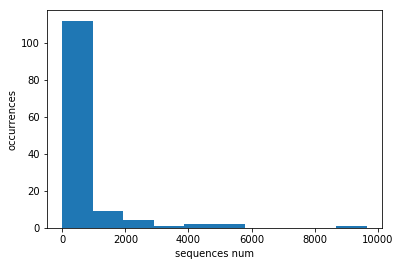

In [431]:
from collections import Counter
import matplotlib.pyplot as plt
counted = Counter(data['country'])
cnt = list(filter(lambda x: x < 10000, counted.values()))
plt.hist(list(cnt))
plt.xlabel('sequences num')
plt.ylabel('occurrences')
plt.show()

In [11]:
list(filter(lambda x: x[1] > 2000, dict(counted).items()))

[('Australia', 16540),
 ('Belgium', 2731),
 ('Netherlands', 4587),
 ('Canada', 3604),
 ('Denmark', 16790),
 ('United Kingdom', 137179),
 ('France', 2726),
 ('India', 4236),
 ('Japan', 9649),
 ('Portugal', 2203),
 ('USA', 52254),
 ('South Africa', 2801),
 ('Spain', 5612),
 ('Switzerland', 4953)]

Manually select featured: small countries with many secuences processed

In [515]:
top_countries = ['Belgium', 'Netherlands', 'Denmark', 'France', 'Japan', 'Portugal', 'Spain', 'Switzerland'] # 'South Africa'

## Prepare country-separated data

In [13]:
from collections import defaultdict
top_countries_dict = data.loc[data['country'].isin(top_countries)]['country'].to_dict()
grouped_ids = defaultdict(set)
for k, v in top_countries_dict.items():
    grouped_ids[v].add(k)

In [72]:
def create_country_file(country):
    with open('COVID data/msa_1229/msa_1229.fasta') as f:
        meta = f.readline()
        v = 0

        while meta:
            sequence = f.readline()
            if country in meta:
                with open(f"COVID data/msa_1229/countries/{country}.fasta", "a+") as cf:
                    cf.writelines([meta, sequence])
            v += 1

            meta = f.readline()

    print(v)

In [73]:
create_country_file("Belgium")

276018


In [31]:
metas = 0
v = 0
ids = set(data.loc[data['country'] == 'Belgium']['strain'].tolist())

bel_ids = set()

with open('COVID data/msa_1229/msa_1229.fasta') as f:
    meta = f.readline()
    while meta:
        sequence = f.readline()
        id_ = meta.split("|")[0][9:]
        if id_ in ids:
            bel_ids.add(id_)
        
        meta = f.readline()

In [17]:
from tqdm import tqdm

belgium = []
metas = []
common_len = 0
with open("COVID data/Belgium.fasta", "r") as cf:
    meta = cf.readline()
    while meta:
        seq = cf.readline()
        metas.append(meta)
        belgium.append(seq)  
        meta = cf.readline()
    
print(len(belgium))

final_sequences = []
spaces = []
for seq in tqdm(list(zip(*belgium))):
    spaces.append(seq.count('-') * 1.0 / len(seq))
    if seq.count('-') * 1.0 / len(seq) > 0.1:
        continue
    final_sequences.append(seq)
print((final_sequences))

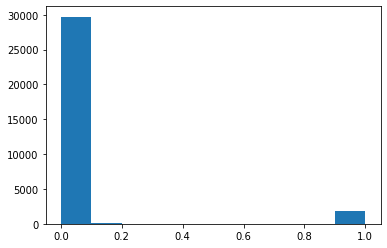

In [77]:
plt.hist(spaces)
plt.show()

## Sequences analysis

Draw hist for some subtrees and trendline to understend dynamics of key mutations distrubution

In [505]:
import io
from newick import load

def load_tree(path):
    with io.open(path, encoding='utf8') as fp:
        return load(fp)[0]

In [753]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def get_date_from_meta(meta):
    return meta.split("|")[2]

def get_id_from_meta(meta):
    return meta.split("/")[2]

def get_timestamp(date: str):
    return mdates.epoch2num(datetime.strptime(date, '%Y-%m-%d').timestamp())

def generate_bins_from_dates(start_date, end_date, timerange):
    start = pd.Timestamp(start_date)
    end = pd.Timestamp(end_date)
    parts = list(pd.date_range(start, end, freq=timerange))
    parts_with_borders = []
    if len(parts) != 0:
        parts_with_borders = [parts[0] - pd.to_timedelta(timerange)] + parts + \
            [parts[-1] + pd.to_timedelta(timerange)]
    else: #fix only for one week timerange
        number_of_days = int(start.weekday()) + 1
        parts = [start - pd.to_timedelta(f'{number_of_days}d')]
        parts_with_borders = parts + [parts[-1] + pd.to_timedelta(timerange)]
        
    return list(map(lambda x: x.to_pydatetime().timestamp(), parts_with_borders))


def show_hist(n, bins, polynom=None, approx_polynom=None, width=1):
    fig, ax = plt.subplots(1,1)
    ax.bar(bins[:-1], n, width=width)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
    if polynom is not None:
        ax.plot(bins, polynom(bins), "r--")
    plt.xlabel('date')
    plt.ylabel('%')
    if approx_polynom is not None:
        y = [np.polyval(approx_polynom, i - bins[0]) for i in bins]
        ax.plot(bins, y)
    plt.show()

def prepare_hist(leaves):
#     bounds = (get_timestamp('2019-12-24'), get_timestamp('2021-01-10'))
    dates = []
    for leaf in leaves:
        try:
            dates.append(datetime.strptime(get_date_from_meta(leaf), '%Y-%m-%d'))
        except:
            try:
                dates.append(datetime.strptime(get_date_from_meta(leaf), '%Y-%m-00'))
            except:
                pass
#     print(dates)
    bins = list(map(mdates.epoch2num, generate_bins_from_dates(min(dates), max(dates), '1w')))
    return np.histogram(list(map(lambda x: mdates.epoch2num(x.timestamp()), dates)), bins=bins)
    
def draw_date_histogramm_by_subtree(leaves, totals, force_draw=False, min_k=0.02):
    ns, bins = prepare_hist(leaves)
    n1 = []
    for n, b in zip (ns, bins):
        n1.append(n / totals[b] * 100 if n != 0 else 0)
    ns = n1
# #     print(m)
# #     ns = np.vectorize(lambda x: x * m / approx_p(x))(ns)
#     n1 = []
#     for n, x in zip(ns, bins):
#         t = n + (m - approx_p(x - s))
# #         print(n, approx_p(x - s), t)
#         n1.append(t)
#     ns=n1
    
    z = np.polyfit(bins[:-1], ns, 1)
    if z[0] > min_k or force_draw:
        print(f'Subtree size: {len(leaves)}')
        print(f'Trendline coefficient: {z[0]}')
        p = np.poly1d(z)
        show_hist(ns, bins, p)
        
def prepare_approx(n, bins):
    approx = np.polyfit(bins[:-1] - bins[0], n, 10)
    return np.poly1d(approx), n.mean()

def prepare_totals(tree):
    leaves = tree.get_leaf_names()
    ns, bins = prepare_hist(leaves)
    return {b: n for n, b in zip(ns, bins)}

{737456.875: 1, 737463.875: 0, 737470.875: 0, 737477.875: 1, 737484.875: 99, 737491.875: 43, 737498.875: 90, 737505.875: 233, 737512.875: 187, 737519.875: 193, 737526.875: 94, 737533.875: 44, 737540.875: 68, 737547.875: 50, 737554.875: 47, 737561.875: 19, 737568.875: 5, 737575.875: 6, 737582.875: 7, 737589.875: 29, 737596.875: 10, 737603.875: 15, 737610.875: 18, 737617.875: 17, 737624.875: 61, 737631.875: 78, 737638.875: 94, 737645.875: 29, 737652.875: 27, 737659.875: 16, 737666.875: 29, 737673.875: 50, 737680.875: 119, 737687.875: 86, 737694.875: 10, 737701.875: 52, 737708.875: 17, 737715.875: 231, 737722.875: 116, 737729.875: 19, 737736.875: 114, 737743.875: 57, 737750.875: 63, 737757.875: 43}
Subtree size: 2587
Trendline coefficient: 0.08053961542343485


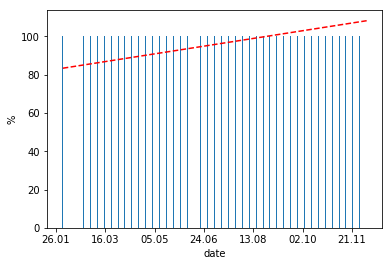

In [756]:
leaves = tree2.get_leaf_names()
# n, bins = prepare_hist(leaves)
# approx_p, m = prepare_approx(n, bins)
totals = prepare_totals(tree2)
print(totals)
draw_date_histogramm_by_subtree(leaves, totals, force_draw=True)

51.74
Subtree size: 2587
Trendline coefficient: 0.028486642181781287


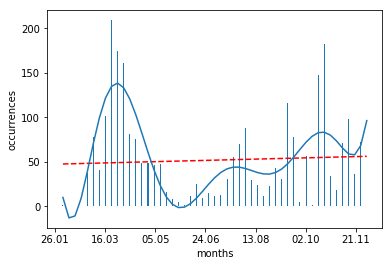

In [644]:
leaves = tree2.get_leaf_names()
n, bins = prepare_hist(leaves, 50)
approx_p, m = prepare_approx(n, bins)
draw_date_histogramm_by_subtree(leaves, approx_p, m, bins[0], force_draw=True)



Belgium

Subtree size: 99
Trendline coefficient: 0.1451823817626497


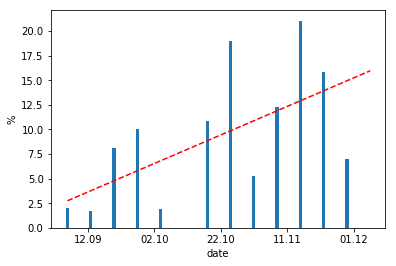

Subtree size: 55
Trendline coefficient: 0.2425257834650584


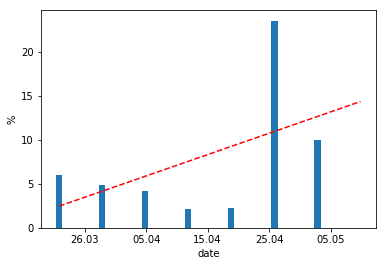

Subtree size: 96
Trendline coefficient: 0.1201920821999854


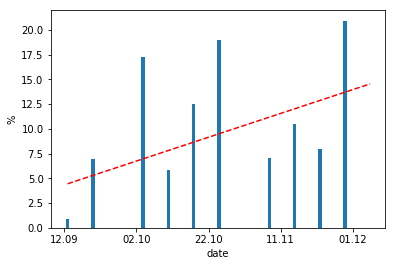

Subtree size: 66
Trendline coefficient: 0.12324955407416333


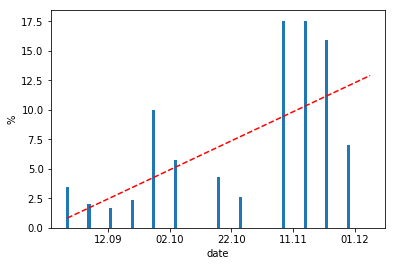

Subtree size: 45
Trendline coefficient: 0.1585666852117845


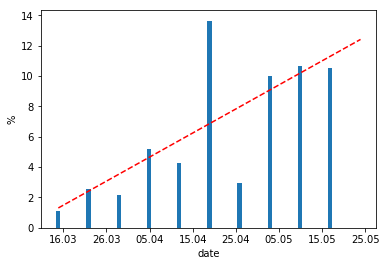



Netherlands

Subtree size: 54
Trendline coefficient: 0.17808184558970663


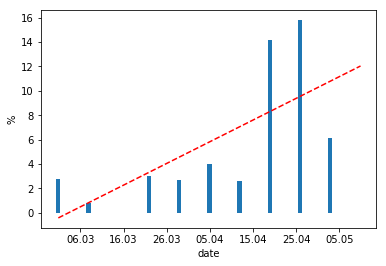



Denmark

Subtree size: 35
Trendline coefficient: 0.11500880729377776


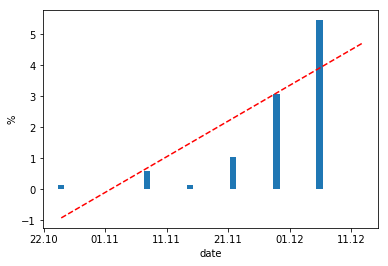

Subtree size: 98
Trendline coefficient: 0.1972009061549199


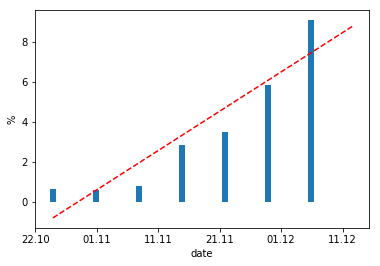

Subtree size: 95
Trendline coefficient: 0.11692770862568572


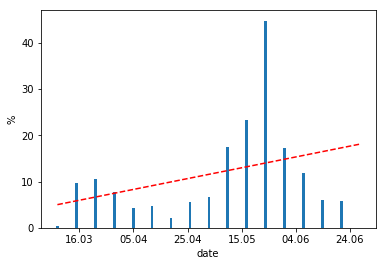

Subtree size: 98
Trendline coefficient: 0.14947737676620768


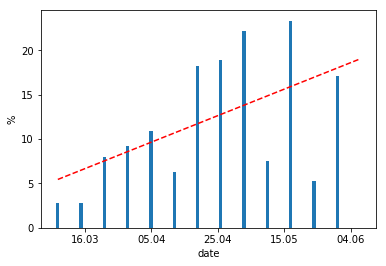



France



Japan

Subtree size: 58
Trendline coefficient: 0.15486326732772607


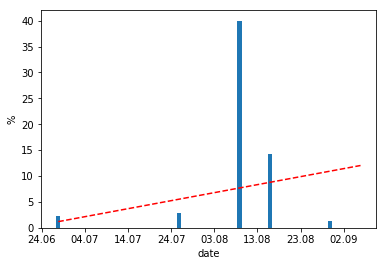

Subtree size: 30
Trendline coefficient: 0.13443905532164485


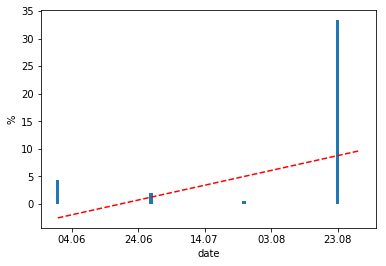

Subtree size: 64
Trendline coefficient: 0.14244682682194384


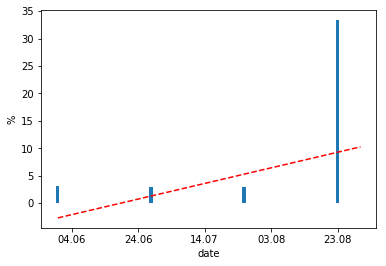

Subtree size: 37
Trendline coefficient: 0.28217169220644095


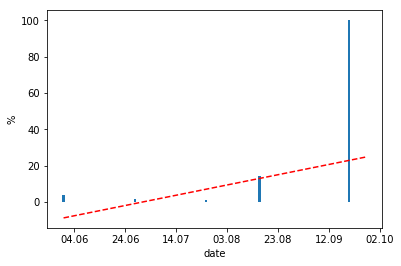

Subtree size: 57
Trendline coefficient: 0.20473527141915726


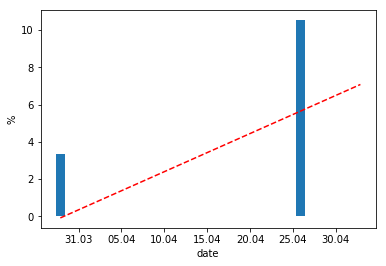

Subtree size: 90
Trendline coefficient: 0.14776683048655614


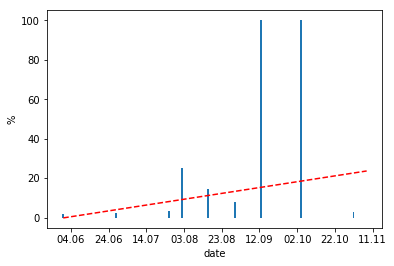

Subtree size: 75
Trendline coefficient: 0.6510505850075321


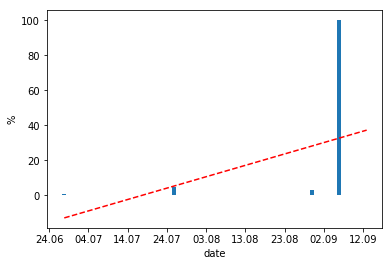

Subtree size: 71
Trendline coefficient: 0.16833292115948315


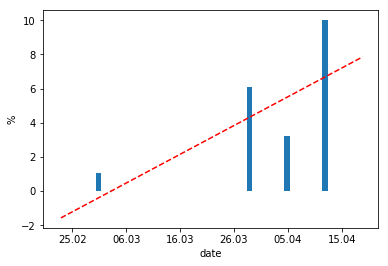



Portugal

Subtree size: 96
Trendline coefficient: 0.179667096379861


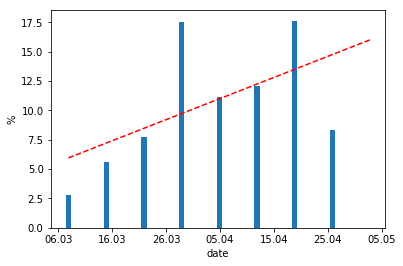

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:22: RankWarning: Polyfit may be poorly conditioned


Subtree size: 40
Trendline coefficient: 0.17948287983205052


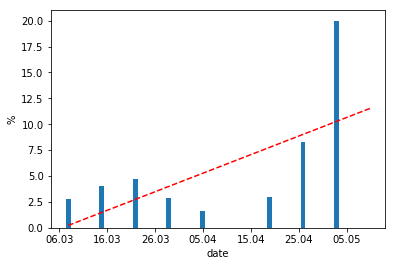

Subtree size: 37
Trendline coefficient: 0.10694243915563599


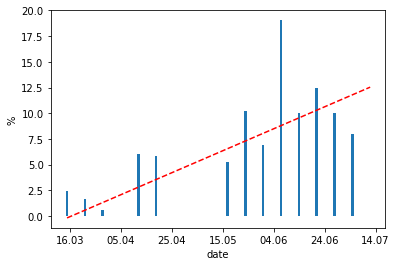

Subtree size: 33
Trendline coefficient: 0.26142766261817263


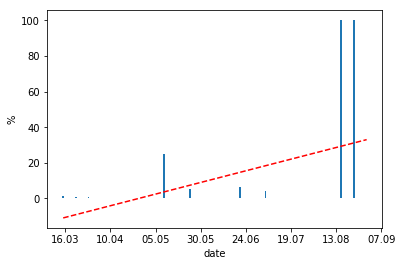



Spain

Subtree size: 87
Trendline coefficient: 0.47270021570103876


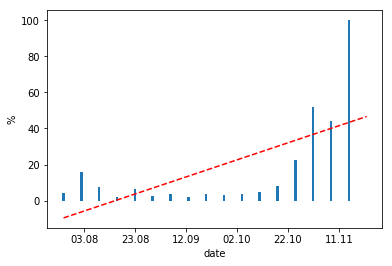



Switzerland

Subtree size: 50
Trendline coefficient: 0.21817956702487798


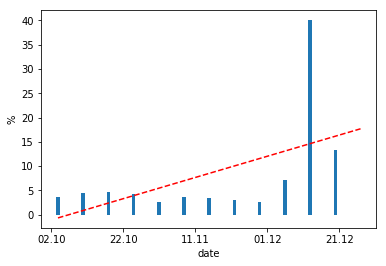

In [755]:
import os

def _dig(node, stop_fn):
    if not stop_fn(node):
        res = []
        for descendant in node.descendants:
            if not descendant.is_leaf:
                res += _dig(descendant, stop_fn)
        return res
    else:
        return [node]

def analyze_subtrees(tree, size_range=(30, 100)):
    n, bins = prepare_hist(tree.get_leaf_names())
#     approx_p, m = prepare_approx(n, bins)
    totals = prepare_totals(tree)
    for i in _dig(tree, lambda node: len(node.get_leaves()) < size_range[1]):
        leaves = i.get_leaf_names()
        if len(leaves) < size_range[0]:
            continue
#         print(leaves)
        draw_date_histogramm_by_subtree(leaves, totals, min_k=0.1)


for country in top_countries:
    print(f'\n\n{country}\n')
    tree = load_tree(os.path.join('COVID data', 'countries', country, 'tree.nwk'))
    analyze_subtrees(tree)

In [666]:
# tree = load_tree(os.path.join('COVID data', 'countries', 'Denmark', 'tree.nwk'))
analyze_subtrees(tree, size_range=(300, 1000))